In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy

import sys
from pathlib import Path
fun_lib_path = Path.home() / 'git/alexei_fun_lib' 
sys.path.append(str(fun_lib_path))

import matplotlib_funs as mpf
import numerical_funs as nf
import general_funs as gef
import optics_funs as of

import peak_finder as pkf

import h5py

In [3]:
hdf5 = h5py.File('./H1_OMC_DCPD_SUM_OUT_DQ-1219517958-270.h5','r')

In [4]:
key = list(hdf5.keys())[0]
display(key)

group = hdf5[key]

display(group)

memebers = list(group.keys())
display(memebers)

'1219517958-270'

<HDF5 group "/1219517958-270" (1 members)>

['H1:OMC-DCPD_SUM_OUT_DQ,raw']

In [5]:
dcpd_raw = np.array(group[memebers[0]])

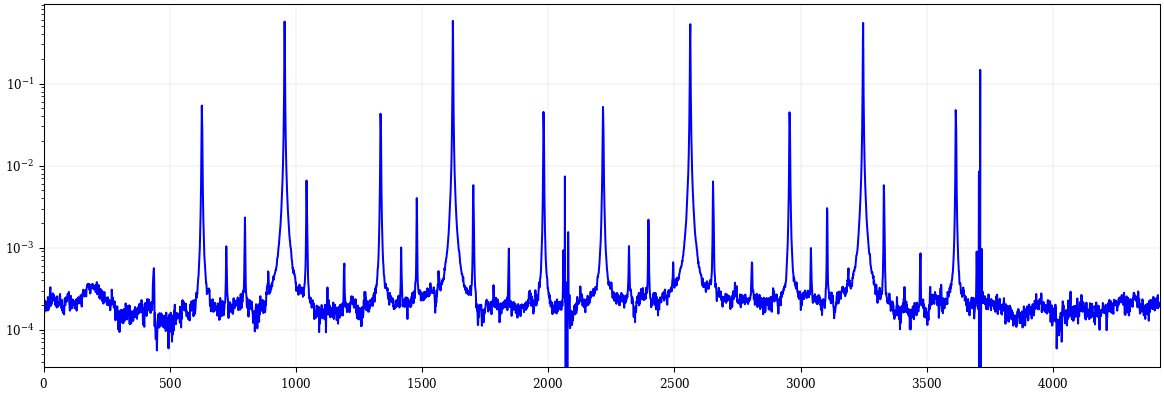

In [6]:
plt.figure(figsize=[15,5])
plt.semilogy(dcpd_raw[::1000])
# plt.ylim([1e-4,1e0])

In [7]:
y_slc = dcpd_raw[2400000:3400000]

dt = 1/2**14

t_slc = np.arange(len(y_slc))*dt

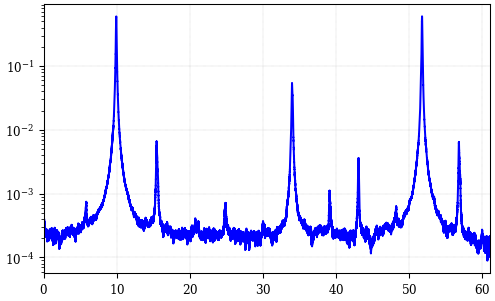

In [8]:
plt.semilogy(t_slc, y_slc)

In [9]:
sos = scipy.signal.butter(4, 0.01, 'low', output='sos')
y_filt = scipy.signal.sosfiltfilt(sos, y_slc)

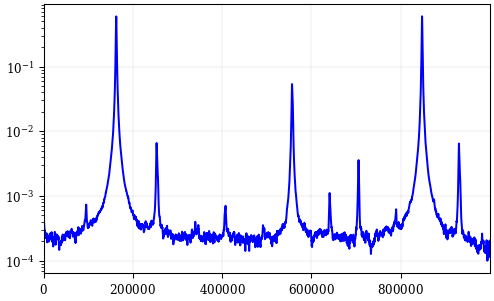

In [10]:
plt.semilogy(y_filt)

In [11]:
# _, pk_ind = pkf.my_peak_det_bs(y_filt, num_peaks=8)
# print(_)
pk_ind = pkf.peakdet(y_filt, 0.00044)

In [12]:
tem_00, tem_04, tem_03, tem_02, tem_06, tem_01, tem_00_b, tem_04_b = pk_ind

In [99]:
y_slc[tem_01]/y_slc[tem_00]

0.0060041398

In [100]:
y_slc[tem_02]/y_slc[tem_00]

0.090042733

In [13]:
tem_05_a = pkf.win_max_find_2(y_filt, 1e5)
tem_05_b = pkf.win_max_find_2(y_filt, 7.9e5)

0.26945
0.5
0.48255
0.5


/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_squeezer_OMC_astigmatism/../LHO_full_OMC_scan.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_squeezer_OMC_astigmatism/../LHO_full_OMC_scan.pdf


0

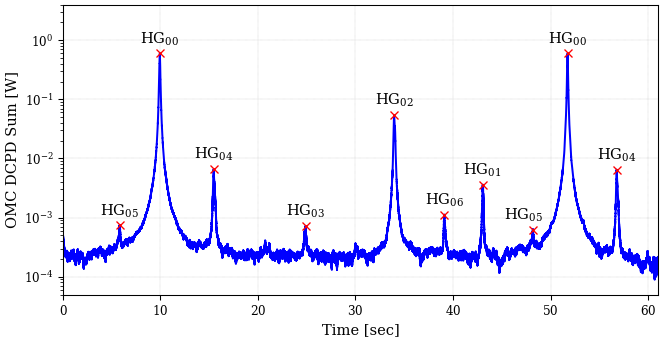

In [14]:
fig = plt.figure(figsize=[8,4])
plt.semilogy(t_slc, y_slc)
for pk in pk_ind:
    plt.plot(t_slc[pk], y_slc[pk], 'x', c='r')
    
plt.plot(t_slc[tem_05_a], y_slc[tem_05_a], 'x', c='r')
plt.plot(t_slc[tem_05_b], y_slc[tem_05_b], 'x', c='r')

plt.text(t_slc[tem_00] - 2, y_slc[tem_00]*1.5, 'HG$_{00}$')
plt.text(t_slc[tem_01] - 2, y_slc[tem_01]*1.5, 'HG$_{01}$')
plt.text(t_slc[tem_02] - 2, y_slc[tem_02]*1.5, 'HG$_{02}$')
plt.text(t_slc[tem_03] - 2, y_slc[tem_03]*1.5, 'HG$_{03}$')
plt.text(t_slc[tem_04] - 2, y_slc[tem_04]*1.5, 'HG$_{04}$')
plt.text(t_slc[tem_06] - 2, y_slc[tem_06]*1.5, 'HG$_{06}$')
plt.text(t_slc[tem_05_a] - 2, y_slc[tem_05_a]*1.5, 'HG$_{05}$')
plt.text(t_slc[tem_05_b] - 3, y_slc[tem_05_b]*1.5, 'HG$_{05}$')
plt.text(t_slc[tem_04_b] - 2, y_slc[tem_04_b]*1.5, 'HG$_{04}$')
plt.text(t_slc[tem_00_b] - 2, y_slc[tem_00_b]*1.5, 'HG$_{00}$')

plt.ylim([None, 2])

plt.ylabel('OMC DCPD Sum [W]')
plt.xlabel('Time [sec]')
plt.ylim([5e-5, 4])

mpf.thesis_savefig(fig, '../LHO_full_OMC_scan', resize=False)

In [82]:
y_02_slc = y_slc[tem_02-7000:tem_02+8000]
t_02_slc = np.arange(len(y_02_slc))*dt

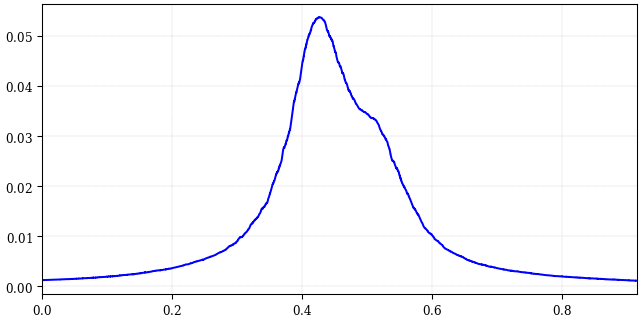

In [83]:
fig = plt.figure(figsize=[8,4])
plt.plot(t_02_slc, y_02_slc)

In [84]:
def lorentzian(x,fwhm=1,x0=0):
    '''maximum of lorentzian is 1.0'''
    return (fwhm/2)**2/((x-x0)**2+(fwhm/2)**2)

In [85]:
_t_lstsq_sol = [None]
def objective_function(theta, x, y, lstsq_sol=None, mode='resid'):
    fwhm, *xis = theta
    N = len(x)
    Nx = len(xis)
    
    a = np.zeros([N,1+Nx])
    a[:,0] = np.ones(N)
    for i, xi in enumerate(xis):
        a[:,i+1] = lorentzian(x, fwhm, xi)
    
    if lstsq_sol is None:
        lstsq_sol, *_ = np.linalg.lstsq(a, y, rcond=None)
        # print(lstsq_sol)
        _t_lstsq_sol[0] = lstsq_sol # write lstsq solution to global
    
    model = np.sum(lstsq_sol*a, axis=1)
    
    if mode == 'resid':
        out =  y-model
    elif mode == 'model':
        out = model
    return out

In [86]:
init_1 = [0.1, 0.4]

soln_1 = scipy.optimize.least_squares(objective_function, init_1, args=(t_02_slc, y_02_slc), ftol=3e-16, gtol=3e-16, xtol=3e-16)
lstsq_sol_1 = _t_lstsq_sol[0]

model_1 = objective_function(soln_1.x, t_02_slc, y_02_slc, lstsq_sol=lstsq_sol_1, mode='model')

/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_squeezer_OMC_astigmatism/../single_fit.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_squeezer_OMC_astigmatism/../single_fit.pdf


0

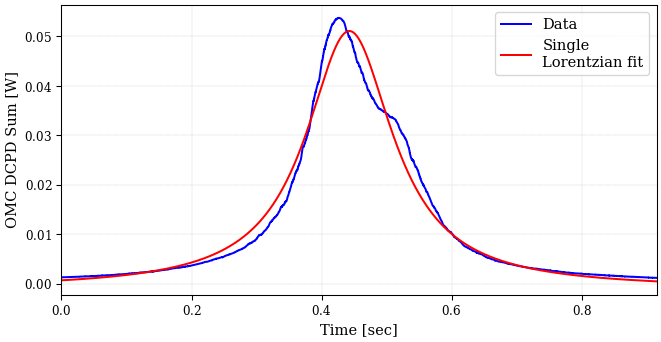

In [97]:
fig = plt.figure(figsize=[8,4])
plt.plot(t_02_slc, y_02_slc, label='Data')
plt.plot(t_02_slc, model_1, label='Single\nLorentzian fit')
plt.legend()
plt.xlabel('Time [sec]')
plt.ylabel('OMC DCPD Sum [W]')
mpf.thesis_savefig(fig, '../single_fit', resize=False)

In [90]:
init_2 = [0.1, 0.4, 0.5]

soln_2 = scipy.optimize.least_squares(objective_function, init_2, args=(t_02_slc, y_02_slc), ftol=3e-16, gtol=3e-16, xtol=3e-16)
lstsq_sol_2 = _t_lstsq_sol[0]

model_2 = objective_function(soln_2.x, t_02_slc, y_02_slc, lstsq_sol=lstsq_sol_2, mode='model')

l1 = soln_2.x[0], soln_2.x[1]
l2 = soln_2.x[0], soln_2.x[2]

L1 = lorentzian(t_02_slc, *l1) * lstsq_sol_2[1]
L2 = lorentzian(t_02_slc, *l2) * lstsq_sol_2[2]

/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_squeezer_OMC_astigmatism/../double_fit.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/LHO_squeezer_OMC_astigmatism/../double_fit.pdf


0

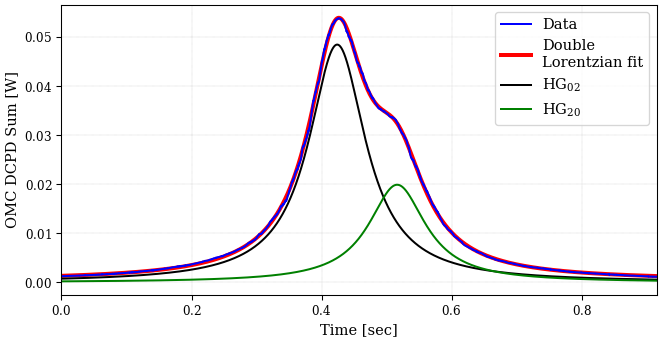

In [101]:
fig = plt.figure(figsize=[8,4])
plt.plot(t_02_slc, y_02_slc, zorder=2, label='Data')
plt.plot(t_02_slc, model_2, zorder=1, lw=3, label='Double\nLorentzian fit')
plt.plot(t_02_slc, L1, label='HG$_{02}$')
plt.plot(t_02_slc, L2, c='g', label='HG$_{20}$')
plt.legend()
plt.xlabel('Time [sec]')
plt.ylabel('OMC DCPD Sum [W]')
mpf.thesis_savefig(fig, '../double_fit', resize=False)

In [92]:
(soln_2.x[2] - soln_2.x[1])/(2*soln_2.x[0])

0.43245578796931977